# 作業: 使用 RNN 實作手寫數字辨識 (Handwritten number recognition with RNN)


##[作業目標 - Objectives] 

*   使用 Pytorch 的 RNN - Use RNN in Pytorch
*   熟練建構 RNN 網路 - Construct an RNN model
*   RNN 也可以用在簡單的影像識別應用，準確度高達 90% 以上 - Use the RNN model in image recognition (accuracy > 90%) 

### [動手做 - Implementation]
*   在 ImageRNN 類別裡面完成 RNN 物件 basic_rnn 的建立
*   在 ImageRNN 類別裡面完成 全連結層 FC 物件的建立

##[作業重點]

順利實作出手寫數字辨識的 RNN 模型
*   使用 torchvision 提供的手寫數字資料集
*   架構 ImageRNN 類別




### 載入會使用到的套件

In [1]:
import torch
from torch import nn   
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### 定義超參數

In [2]:
# 超參數 Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

### 載入訓練資料
建立 train_loader 物件用來載入訓練資料


In [3]:

# 載入手寫數字資料集 Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


### 載入測試資料
建立 test_loader 物件用來載入訓練資料

In [4]:

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 把資料顯示出來看看

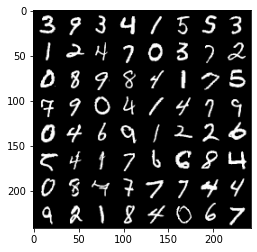

In [5]:
import numpy as np
# Exploring the dataset

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

### 根據資料集的特性，定義資料參數

In [6]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 5

### 架構 RNN 網路

In [15]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # 作業: 請查看 pytorch 文件，選用最基本的 RNN 來當作模型
        self.basic_rnn = torch.nn.RNN(self.n_inputs, self.n_neurons)
        
        # 作業: 定義一個全連結層
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

### 實作訓練程式

In [16]:
import torch.optim as optim

# use gpu if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# instantiate model
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7606 | Train Accuracy: 76.05
Epoch:  1 | Loss: 0.3389 | Train Accuracy: 90.28
Epoch:  2 | Loss: 0.2371 | Train Accuracy: 93.37
Epoch:  3 | Loss: 0.1944 | Train Accuracy: 94.61
Epoch:  4 | Loss: 0.1765 | Train Accuracy: 95.12


### 實作測試程式

In [17]:
# Calculate test accuracy
test_acc = 0.0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 94.83


### RNN Notes

- Standard output of RNN: $h^t_k = \sigma(W^T_h h^{t-1} + W^T_xX^t + b_k)$ 
- Single RNN: 
```python
  class SingleRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
      super(SingleRNN, self).__init__()
      self.Wx = torch.randn(n_inputs, n_neurons)  # input weight of x
      self.Wy = torch.randn(n_neurons, n_neurons) # output weight of y (previous layer) 

      self.b = torch.zeros(1, n_neurons) # bias

    def forward(self, X0, X1):
      """
      forward propagation * 1
      """
      # t = 0 
      self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b)
      # t = 1
      self.Y1 = torh.tanh(torch.mm(self.Y0, self.Wy) + 
                          torch.mm(X1, self.Wx + self.b) 
      return self.Y0, self.Y1
```
- Executing the SingleRNN() function
```python
  n_inputs = 4
  n_neurons = 1

  X0 = torch.tensor([[0,1,2,0], [3,4,5,0], [6,7,8,0], [3,2,1,0]], dtype = torch.float)
  X1 = torch.tensor([[9,8,7,0], [0,0,0,0], [6,5,4,0], [3,2,1,0]], dtype = torch.float)

  model = SingleRNN(n_inputs, n_neurons) 

  Y0_val, Y1_val = model(X0, X1)
```